## Breaking Captchas using Keras CNN

In [2]:
# Imports
import numpy as np
import os
import pickle

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, concatenate
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta
from matplotlib import pyplot as plt
from keras.models import model_from_json
from PIL import Image
import glob
import cv2

%matplotlib inline

/home/yan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from python_anticaptcha import AnticaptchaClient, ImageToTextTask
import urllib.request
import ssl

## Methods

In [4]:
# useful methods
def captcha_to_vec(captcha):    
    vector = np.zeros(word_len * word_class)
    
    for i,ch in enumerate(captcha):
        idex = i * word_class + char_indices[ch]
        vector[idex] = 1
    return vector

def vec_to_captcha(vec):
    text = []
    vec[vec < 0.5] = 0
        
    char_pos = vec.nonzero()[0]
    
    for i, ch in enumerate(char_pos):
        text.append(captcha_word[ch % word_class])
    return ''.join(text)

## Control Variables

In [5]:
download = 0
resize = 0
captcha = 0
api_key = '27872f336948e28bf905e61f192b9148'

## Codes

In [6]:
# download file
if (download == 1):
    
    ssl._create_default_https_context = ssl._create_unverified_context

    for i in range(0,50):
        url = 'https://siconfi.tesouro.gov.br/siconfi/imageCaptcha'
        urllib.request.urlretrieve(url, "mais_imagens/{}.png".format(i))

In [7]:
# resize img

if (resize == 1):
    
    train_dir_raw = r'/home/yan/jupyter notebooks/mais_imagens'
    train_dir_output = r'/home/yan/jupyter notebooks/imagens_novas_ready'


    for item in os.listdir(train_dir_raw):
        img_raw = Image.open(train_dir_raw + '/' + item)
        width, height = img_raw.size
        left = 5
        top = 5
        right = width*0.42
        bottom = height*0.9
        img_output = img_raw.crop((left, top, right, bottom))
        img_output.save(train_dir_output + '/' + item)

In [8]:
if (captcha == 1):
    
    path_input = r'/home/yan/jupyter notebooks/imagens_novas_ready/'
    path_output = '/home/yan/jupyter notebooks/output_imagens_vai/'

    for i in range(0, 50):
        print (i)
        image_path = path_input + '{}.png'.format(i)
        im = Image.open(image_path)       
        captcha_fp = open(image_path, 'rb')
        client = AnticaptchaClient(api_key)
        task = ImageToTextTask(captcha_fp)
        job = client.createTask(task)
        job.join()
        text_image = job.get_captcha_text()
        text_image = str.lower(text_image)
        im.save(path_output + '{}.png'.format(text_image))

(94, 40)


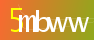

In [9]:
train_dir = r'/home/yan/jupyter notebooks/todas_imagens_certo'

img_path = train_dir + '/' + '5mbww.png'

img = Image.open(img_path)
print (img.size)
img

In [10]:
# parameters

captcha_word = "123456789abcdefghijklmnopqrstuvwxyz"

width = 94
height = 40


word_len = 5
word_class = len(captcha_word)


char_indices = dict((c, i) for i,c in enumerate(captcha_word))
indices_char = dict((i, c) for i,c in enumerate(captcha_word))

In [11]:
test_vec = captcha_to_vec("12345")
vec_test = vec_to_captcha(test_vec)

print(test_vec)
print(vec_test)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
12345


In [12]:
# get image names
image_list = []

i = 0
for item in os.listdir(train_dir):
    image_list.append(item)
    if (i > 1000):
        break
        
    i+=1
    
np.random.shuffle(image_list)
print (image_list[:10])

print (len(image_list))

['r465d.png', 'rmca4.png', '8rara.png', 'd3cg6.png', 'egddc.png', 'r52xw.png', 'p6nng.png', '2363c.png', 'wn75a.png', 'yrmw5.png']
1002


In [13]:
#load images
X = np.zeros((len(image_list), height, width, 3), dtype = np.uint8)
y = np.zeros((len(image_list), word_len * word_class), dtype = np.uint8)

for i,img in enumerate(image_list):
    if i % 100 == 0:
        print(i)
        
    img_path = train_dir + "/" + img
    raw_img = image.load_img(img_path, target_size=(height, width))
    X[i] = image.img_to_array(raw_img)
    y[i] = captcha_to_vec(img.split('.')[0])

0
100
200
300
400
500
600
700
800
900
1000


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [15]:
# Keras CNN (Convolutional Neural Network)
input_tensor = Input(shape=(height, width, 3))

x = input_tensor

x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)


x = Flatten()(x)
x = Dropout(0.5)(x)


x = [Dense(word_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(word_len)]
output = concatenate(x)

In [16]:
# model
model = Model(inputs=input_tensor, outputs=output)

opt = Adadelta(lr=0.03)

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [17]:
checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

model.fit(X_train, y_train, epochs=80, callbacks=[checkpointer, earlystopper], validation_split=0.2)

Train on 760 samples, validate on 191 samples
Epoch 1/80
760/760 [==============================] - 11s 14ms/step - loss: 33.6215 - acc: 0.0158 - val_loss: 24.2558 - val_acc: 0.0157

Epoch 00001: val_loss improved from inf to 24.25578, saving model to bestmodel.hdf5
Epoch 2/80
760/760 [==============================] - 10s 13ms/step - loss: 24.2002 - acc: 0.0158 - val_loss: 24.0782 - val_acc: 0.0105

Epoch 00002: val_loss improved from 24.25578 to 24.07820, saving model to bestmodel.hdf5
Epoch 3/80
760/760 [==============================] - 11s 14ms/step - loss: 23.9299 - acc: 0.0197 - val_loss: 23.9121 - val_acc: 0.0105

Epoch 00003: val_loss improved from 24.07820 to 23.91213, saving model to bestmodel.hdf5
Epoch 4/80
760/760 [==============================] - 11s 14ms/step - loss: 23.6333 - acc: 0.0303 - val_loss: 23.8333 - val_acc: 0.0157

Epoch 00004: val_loss improved from 23.91213 to 23.83333, saving model to bestmodel.hdf5
Epoch 5/80
760/760 [==============================] - 1

760/760 [==============================] - 11s 15ms/step - loss: 8.6325 - acc: 0.4092 - val_loss: 16.8204 - val_acc: 0.5079

Epoch 00041: val_loss did not improve from 15.21115
Epoch 00041: early stopping


In [18]:
# save model as json file
model_json = model.to_json()
with open("model_output/captcha_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_output/model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
# load model from a json file
json_file = open('model_output/captcha_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_output/model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


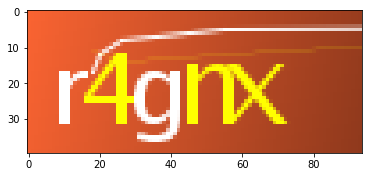

true: r4gnx | predicted: rhyrx


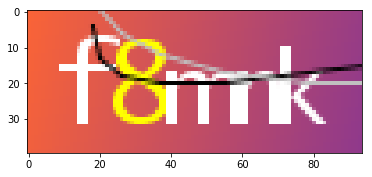

true: f7mnk | predicted: f8n6


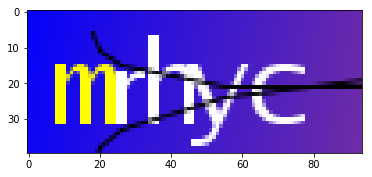

true: mrhyc | predicted: mrkyc


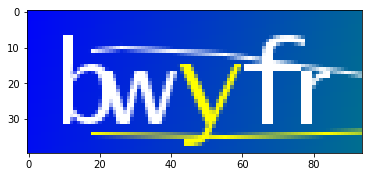

true: bwyfr | predicted: bwyf


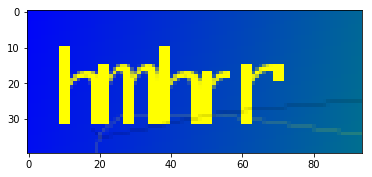

true: hmhrr | predicted: hrhrr


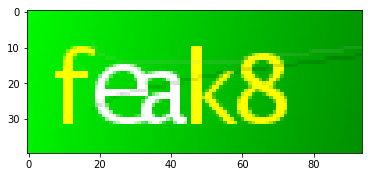

true: feak8 | predicted: fe3k8


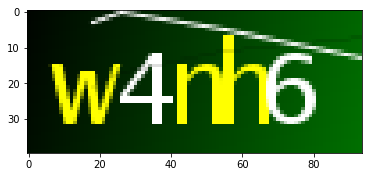

true: w4nh6 | predicted: w4md6


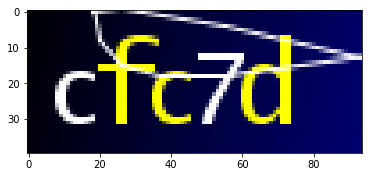

true: cfc7d | predicted: cfdm4


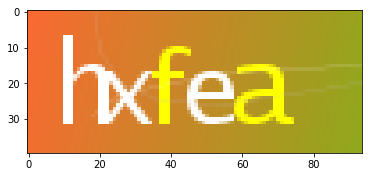

true: hxfea | predicted: hn5ea


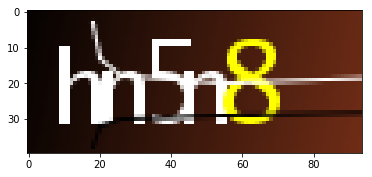

true: hn5n8 | predicted: r53


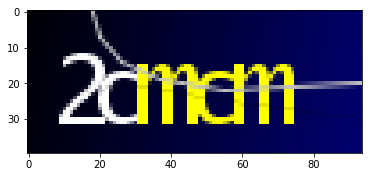

true: 2cmcm | predicted: 2nmgn


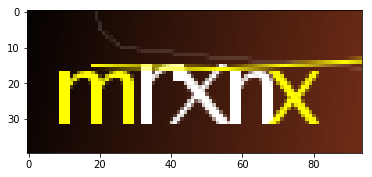

true: mrxnx | predicted: rnrx


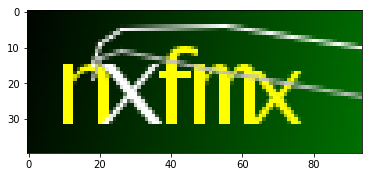

true: nxfmx | predicted: nxhx


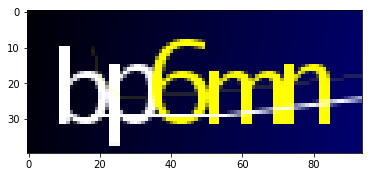

true: bp6mn | predicted: bp6mm


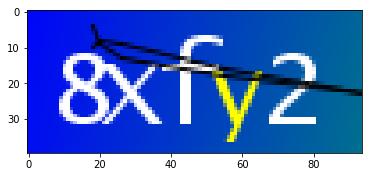

true: 8xfy2 | predicted: 8xfm8


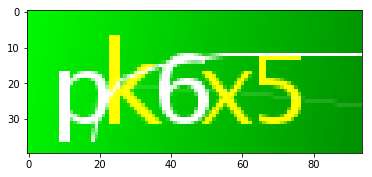

true: pk6x5 | predicted: pk65


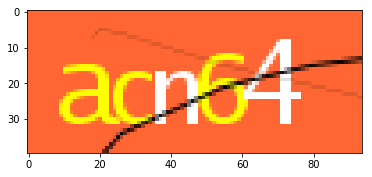

true: acn64 | predicted: a4


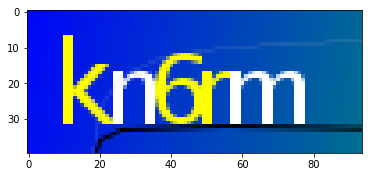

true: kn6rm | predicted: knbrw


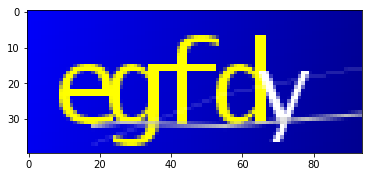

true: egfdy | predicted: egfdy


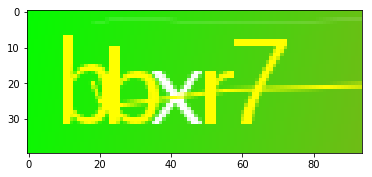

true: bbxr7 | predicted: bbn


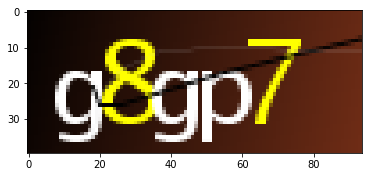

true: g8gp7 | predicted: g8gy7


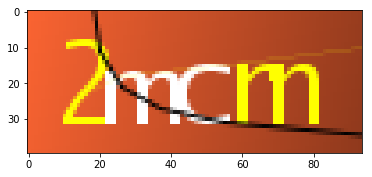

true: 2mcrn | predicted: 2mrfm


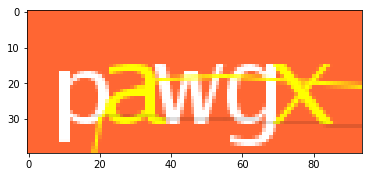

true: pawgx | predicted: pegy


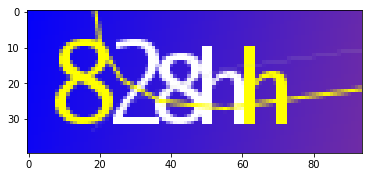

true: 828hh | predicted: 823h4


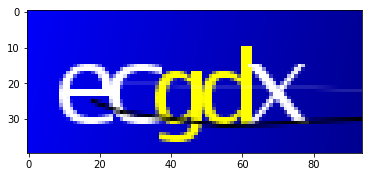

true: ecgdx | predicted: engdx


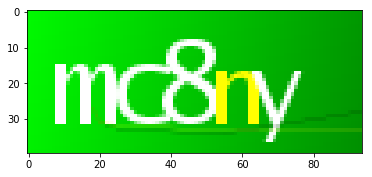

true: mc8ny | predicted: mc2ny


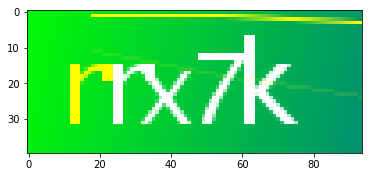

true: rrx7k | predicted: rpr2x


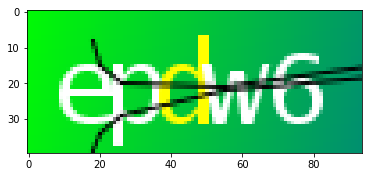

true: epdw6 | predicted: epdw7


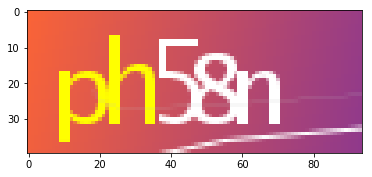

true: ph58n | predicted: pb53n


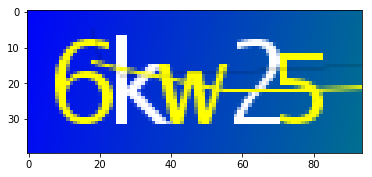

true: 6kw25 | predicted: 6kw8


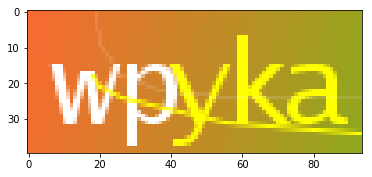

true: wpyka | predicted: mpd


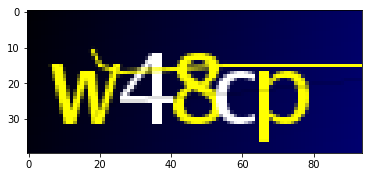

true: w48cp | predicted: w8rp


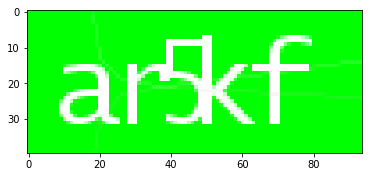

true: ar5kf | predicted: ar5rf


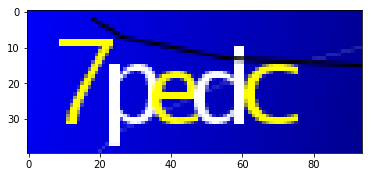

true: 7pedc | predicted: 7padc


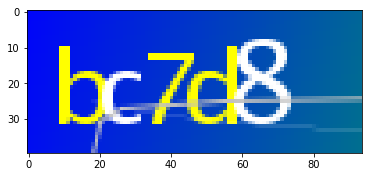

true: bc7d8 | predicted: bc8


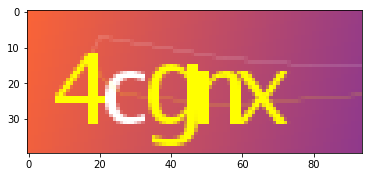

true: 4cgnx | predicted: 4cgrx


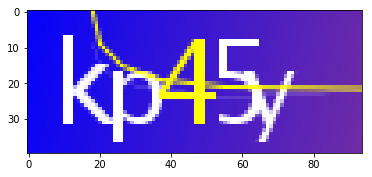

true: kp45y | predicted: kp45y


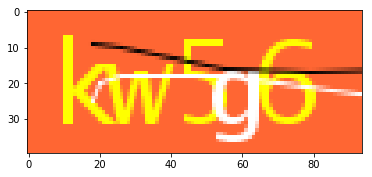

true: kw5g6 | predicted: kndg3


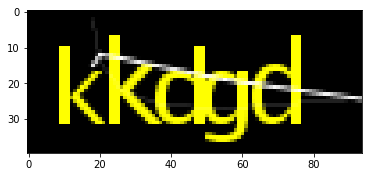

true: kkdgd | predicted: khdgd


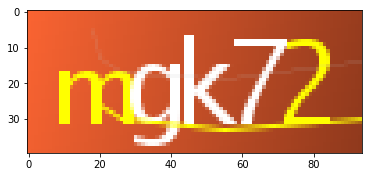

true: mgk72 | predicted: rd7


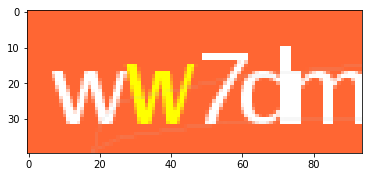

true: ww7dm | predicted: wb


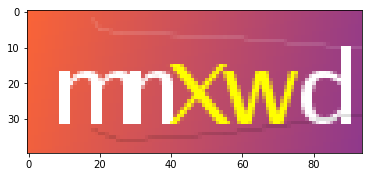

true: mnxwd | predicted: mnmww


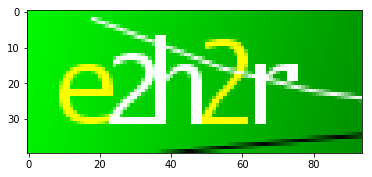

true: e2h2r | predicted: e2hdr


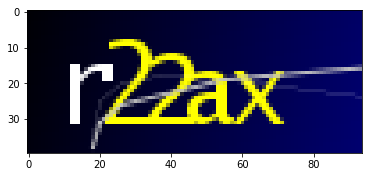

true: r22ax | predicted: r22xr


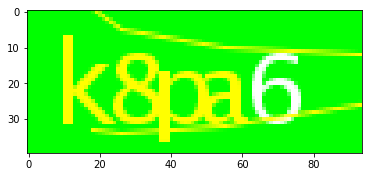

true: k8pa6 | predicted: kgg2


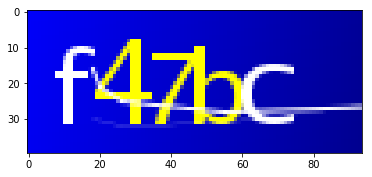

true: f47bc | predicted: fh3bc


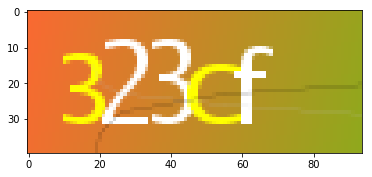

true: 323cf | predicted: 32


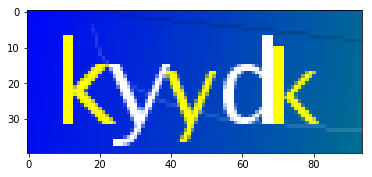

true: kyydk | predicted: kgn2k


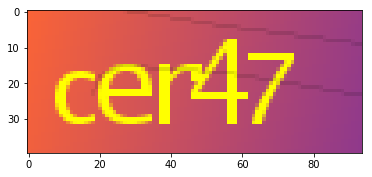

true: cer47 | predicted: cer47


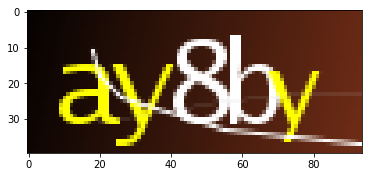

true: ay8by | predicted: ay6dy


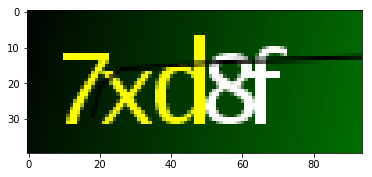

true: 7xd8f | predicted: 7xdhf


In [20]:
#show some results
def testCaptcha(x,y):
    
    result = model.predict(np.array([x]))
    
    vex_test = vec_to_captcha(result[0])
    true_test = vec_to_captcha(y)
    
    plt.imshow(x)
    plt.show()
    
    print("true:",true_test,"| predicted:",vex_test)
    

for x,y in zip(X_test, y_test):
    testCaptcha(x,y)

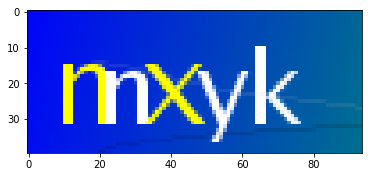

prediction: rwgx


In [21]:
# single test
raw_img = image.load_img(train_dir + '/nnxyk.png', target_size=(height, width))

X_test = np.zeros((1, height, width, 3), dtype = np.float32)
X_test[0] = image.img_to_array(raw_img)
result = model.predict(X_test)

vex_test = vec_to_captcha(result[0])
plt.imshow(raw_img)
plt.show()

print ('prediction:', vex_test)